In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('./data/AAPL.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  object 
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float64
 5   Close           10590 non-null  float64
 6   Adjusted Close  10590 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 579.3+ KB


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


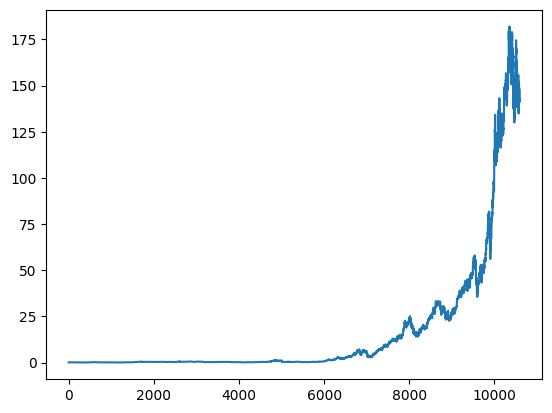

In [6]:
# Выбор колонки для прогноза
close_prices = data['Close'].values.reshape(-1, 1)
plt.plot(close_prices)
plt.show()

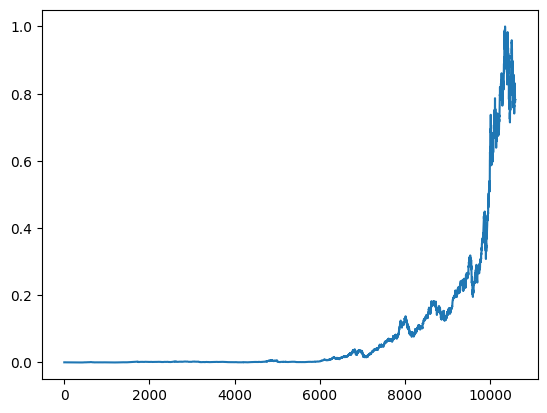

In [5]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)
plt.plot(scaled_data)
plt.show()

In [7]:
# Подготовка временных окон
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 100
X, y = create_dataset(scaled_data, look_back)
# Разделение данных на тренировочные и тестовые
n_test = 500

# Разделение данных
X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]
# Split the remaining data to train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)
print(np.size(X_train, 0))
print(np.size(X_val, 0))

7492
2498


In [46]:
from keras.models import Sequential
from keras.layers import Dense

# Построение модели MLP
mlp_model = Sequential()
mlp_model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dense(1, activation='relu'))

Epoch 1/20
188/188 [==============================] - 1s 4ms/step - loss: 3.2472e-04 - val_loss: 1.3415e-04
Epoch 2/20
188/188 [==============================] - 1s 3ms/step - loss: 6.6184e-05 - val_loss: 3.5008e-05
Epoch 3/20
188/188 [==============================] - 1s 3ms/step - loss: 6.4868e-05 - val_loss: 4.0915e-05
Epoch 4/20
188/188 [==============================] - 1s 3ms/step - loss: 1.0531e-04 - val_loss: 4.7517e-05
Epoch 5/20
188/188 [==============================] - 1s 3ms/step - loss: 4.8335e-05 - val_loss: 9.7838e-05
Epoch 6/20
188/188 [==============================] - 1s 3ms/step - loss: 4.5914e-05 - val_loss: 3.8643e-05
Epoch 7/20
188/188 [==============================] - 1s 3ms/step - loss: 4.8144e-05 - val_loss: 2.3480e-05
Epoch 8/20
188/188 [==============================] - 1s 3ms/step - loss: 4.7000e-05 - val_loss: 3.2828e-05
Epoch 9/20
188/188 [==============================] - 1s 3ms/step - loss: 6.5889e-05 - val_loss: 2.3014e-05
Epoch 10/20
188/188 [=======

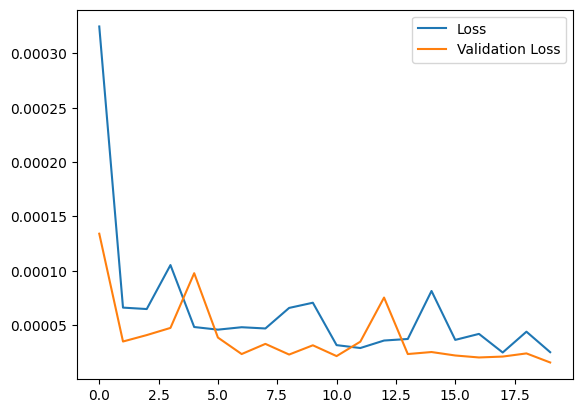

In [47]:
# Компиляция и обучение
mlp_model.compile(optimizer='adam', loss='mean_squared_error')
r = mlp_model.fit(X_train, y_train, batch_size=40, epochs=20, validation_data=(X_val, y_val))
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [48]:
# Прогнозирование
mlp_predictions = mlp_model.predict(X_test)
mlp_predictions_transformed = scaler.inverse_transform(mlp_predictions.reshape(-1, 1))

16/16 [==============================] - 0s 2ms/step


In [11]:
# Преобразование формы для LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [59]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Построение модели LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

Epoch 1/20
188/188 [==============================] - 7s 25ms/step - loss: 5.9197e-04 - val_loss: 4.4853e-05
Epoch 2/20
188/188 [==============================] - 4s 20ms/step - loss: 4.8042e-05 - val_loss: 2.5225e-05
Epoch 3/20
188/188 [==============================] - 4s 21ms/step - loss: 3.5128e-05 - val_loss: 3.7825e-05
Epoch 4/20
188/188 [==============================] - 4s 20ms/step - loss: 4.2493e-05 - val_loss: 3.0761e-05
Epoch 5/20
188/188 [==============================] - 4s 20ms/step - loss: 3.0121e-05 - val_loss: 4.1423e-05
Epoch 6/20
188/188 [==============================] - 4s 20ms/step - loss: 3.3770e-05 - val_loss: 1.9692e-05
Epoch 7/20
188/188 [==============================] - 4s 20ms/step - loss: 3.7033e-05 - val_loss: 3.2420e-05
Epoch 8/20
188/188 [==============================] - 4s 20ms/step - loss: 2.9857e-05 - val_loss: 3.6939e-05
Epoch 9/20
188/188 [==============================] - 4s 20ms/step - loss: 3.0983e-05 - val_loss: 2.9995e-05
Epoch 10/20
188/188

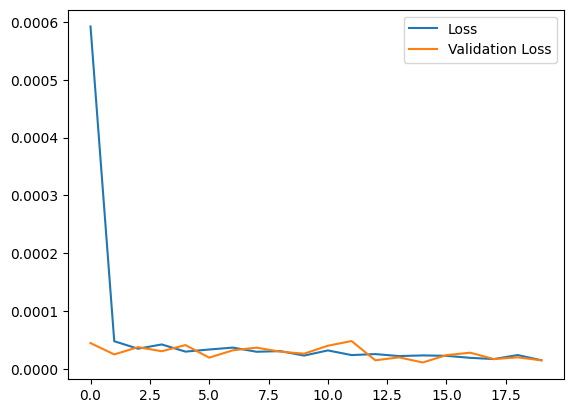

In [60]:
# Компиляция и обучение
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
r = lstm_model.fit(X_train_lstm, y_train, batch_size=40, epochs=20, validation_data=(X_val, y_val))
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [61]:
# Прогнозирование
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions_transformed = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

16/16 [==============================] - 1s 17ms/step


In [72]:
from sklearn.metrics import mean_squared_error

# Оценка моделей
lstm_mse = mean_squared_error(y_test, lstm_predictions)
mlp_mse = mean_squared_error(y_test, mlp_predictions)
print(f'LSTM RMSE: {lstm_mse}')
print(f'MLP RMSE: {mlp_mse}')

LSTM RMSE: 0.0003949601179272417
MLP RMSE: 0.0009430327524044755


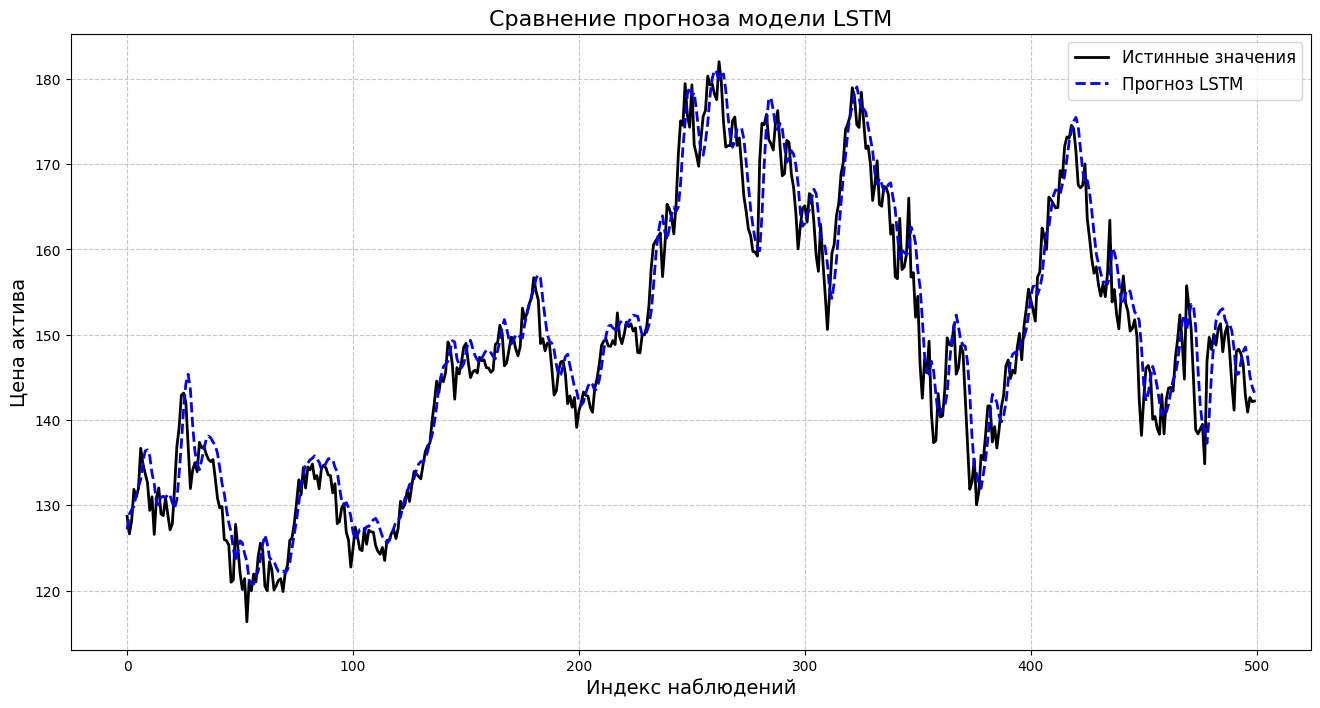

In [79]:
# Восстановление истинных значений
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))
# Визуализация результатов
plt.figure(figsize=(16, 8))
# Истинные значения
plt.plot(true_values, color='black', linestyle='-', label='Истинные значения', linewidth=2)
# Прогнозы LSTM
plt.plot(lstm_predictions_transformed, color='blue', linestyle='--', label='Прогноз LSTM', linewidth=2)
# Заголовок и подписи
plt.title('Сравнение прогноза модели LSTM', fontsize=16)
plt.xlabel('Индекс наблюдений', fontsize=14)
plt.ylabel('Цена актива', fontsize=14)
# Легенда
plt.legend(fontsize=12)
# Сетка
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
# Показ графика
plt.show()

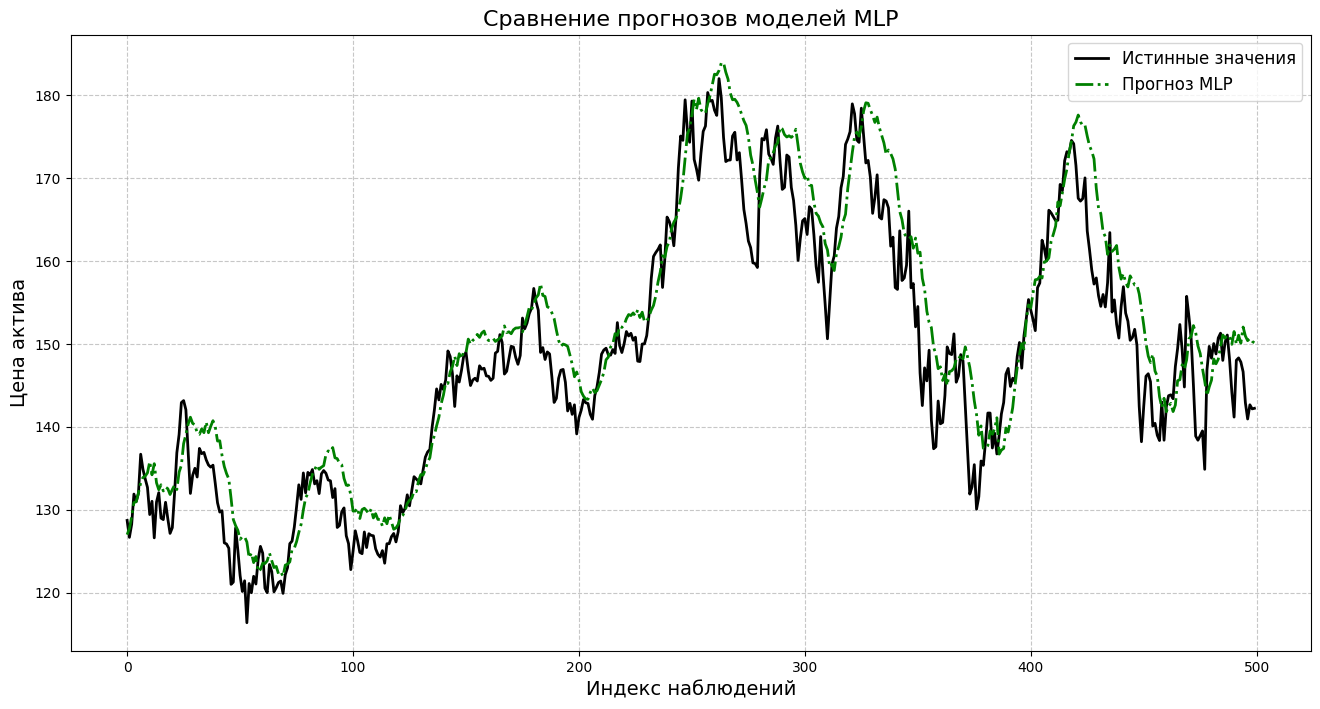

In [78]:
# Визуализация результатов
plt.figure(figsize=(16, 8))
# Истинные значения
plt.plot(true_values, color='black', linestyle='-', label='Истинные значения', linewidth=2)
# Прогнозы MLP
plt.plot(mlp_predictions_transformed, color='green', linestyle='-.', label='Прогноз MLP', linewidth=2)
# Заголовок и подписи
plt.title('Сравнение прогнозов моделей MLP', fontsize=16)
plt.xlabel('Индекс наблюдений', fontsize=14)
plt.ylabel('Цена актива', fontsize=14)
# Легенда
plt.legend(fontsize=12)
# Сетка
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
# Показ графика
plt.show()